In [69]:
## Full backend analysis for the CREEDS and L1000 dataset 
import os
import pandas as pd
from pandas.compat import StringIO
import numpy as np
from numpy import loadtxt
import sys
import json
from pprint import pprint
import requests
import objectpath
import csv
import re
import matplotlib.pyplot as plt
import json, requests
from pprint import pprint
import itertools
import scipy
from scipy.spatial import distance
from sklearn.metrics.pairwise import pairwise_distances
from clustergrammer_widget import *
def get_geneset(df, indexer):
    df_ = df.loc[indexer, :]
    return list(df_[df_ == 1].index)
import seaborn as sns


def fuzzy_search(query, EMR_Drugs):
    return query.lower() in EMR_Drugs.lower()

def fuzzy_search_map(queryset):
    def fuzzy_search_map_inner(query):
        return any([fuzzy_search(queryset_item, query) for queryset_item in queryset])
    return fuzzy_search_map_inner

In [52]:
# load in the EMR Data (filtered > 200 in R code [Drug_diagnosis_test_code.R])
EMR_data = pd.read_csv("EMR_greater_200.csv")
## subset EMR data by the DOI and/or DrOI
EMR_data_df = pd.DataFrame(EMR_data)
#EMR_data
EMR_data_df.drop(EMR_data_df.columns[[0]], axis = 1, inplace = True) # remove the unecessary columns
#EMR_data_df
ehr_drugs = list(EMR_data_df['Drug_Name'])

with open("L1000_CREEDS_Similar_Drug_output.txt", "r") as fd:
    similar_L1000_CREEDS_drugs = fd.read().splitlines()

EMR_drug_subset_df = EMR_data_df[EMR_data_df["Drug_Name"].isin(similar_L1000_CREEDS_drugs)]
total_overlap = pd.read_csv("combined_l1000_creeds.tsv", sep = "\t")

# implement the search from ICD9-do_id from the manual conversion
icd9_to_doid = pd.read_csv("ICD9_CREEDS_conversion.csv")
icd9_to_doid = pd.DataFrame(icd9_to_doid) # convert it to a data fram to drop unecessary rows
#icd9_to_doid # sanity check
icd9_to_doid_final = icd9_to_doid.drop(icd9_to_doid.columns[[0, 6, 7, 8, 9, 10, 11, 12, 13, 14]], axis = 1)  
icd9_codes = list(icd9_to_doid_final["ICD9"])

In [ ]:
### multiply p values to get a mimic or reverse signature for 309 drugs and all CREEDS diseases. 

total_multicol_overlap = pd.read_csv("Total_multicol_combined_l1000_creeds.csv", sep = ",")
#total_multicol_overlap.head()

# -total_multicol_overlap[((total_multicol_overlap['creeds_genes_direction'] == 'up') & (total_multicol_overlap['l1000_genes_direction'] == 'up'))].pivot_table(
#     columns=['l1000_pert_desc', 'l1000_genes_direction'],
#     index=['creeds_disease_name', 'creeds_genes_direction'],
#     values='pvalue',
#     aggfunc='mean',
# )

In [81]:
### improved analysis

EMR_subset_example = EMR_drug_subset_df[EMR_drug_subset_df["Drug_Name"] == "WARFARIN"]

## example with warfarin
EMR_subset_example = EMR_drug_subset_df[EMR_drug_subset_df["Drug_Name"] == "WARFARIN"]

total_example = total_overlap.filter(like = "WARFARIN", axis = 1)
total_example.index = list(total_overlap["Unnamed: 0"])

## just look at specific applications of Taxol (curated manually)

whitelist = ["hypertension",
             "hyperlipidemia",
             "renal",
             "kidney",
             "atrial",
             "diabetes",
             "anticoagulants",
             "coronary",
             "atherosclerosis",
             "congestive",
             "heart",
             "fib",
             "left",
             "right",
             "anemia"
            ]
total_example_subset = total_example.loc[total_example.index.map(fuzzy_search_map(whitelist)), :]
total_example_subset.to_csv("warfarin_example1.tsv", sep ="\t")


# ## clustergrammer implementation
# # load data into new network instance and cluster
# net = Network(clustergrammer_widget)

# net.load_file("warfarin_example1.tsv")
# net.cluster()

# # view the results as a widget
# net.widget()

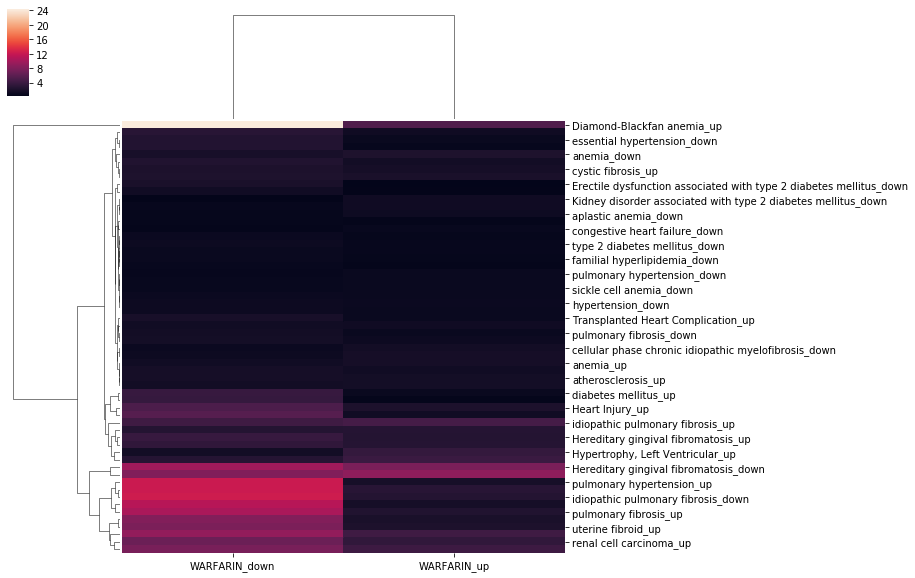

In [83]:
sns.clustermap(-np.log(total_example_subset))

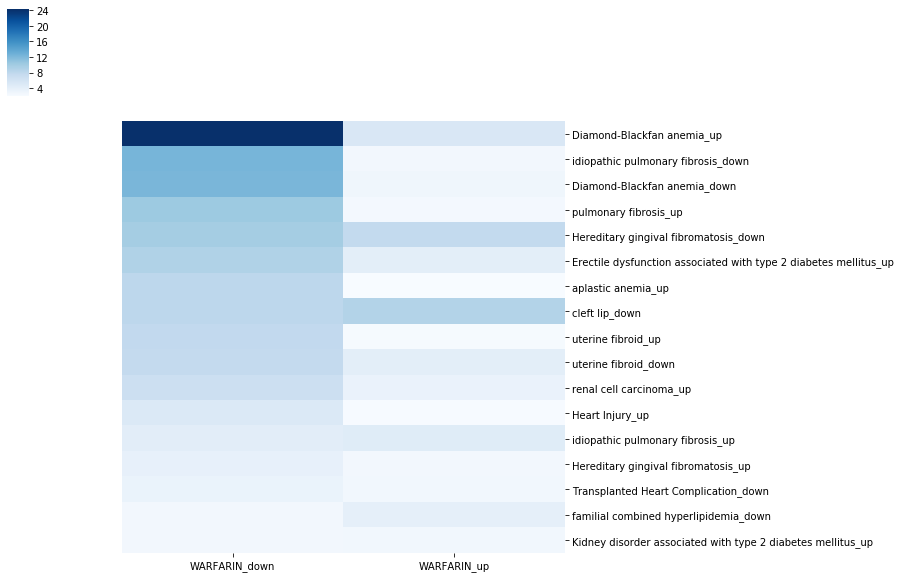

In [112]:
test = pd.DataFrame((total_example_subset[-np.log(total_example_subset) > 2])).dropna()
sns.clustermap(-np.log(test.sort_values("WARFARIN_down", ascending = True)), 
               cmap="Blues", 
               col_cluster=False,
               row_cluster = False
              )

In [108]:
test.sort_values("WARFARIN_down", ascending = True)

,WARFARIN_down,WARFARIN_up
Diamond-Blackfan anemia_up,2.819109e-11,0.004423
idiopathic pulmonary fibrosis_down,3.792340e-06,0.068069
Diamond-Blackfan anemia_down,4.432615e-06,0.053799
pulmonary fibrosis_up,2.910503e-05,0.084143
Hereditary gingival fibromatosis_down,5.093639e-05,0.000400
Erectile dysfunction associated with type 2 diabetes mellitus_up,1.123359e-04,0.012588
aplastic anemia_up,2.647270e-04,0.131474
cleft lip_down,2.681947e-04,0.000127
uterine fibroid_up,3.609273e-04,0.107007
uterine fibroid_down,4.399856e-04,0.013683


In [99]:
#test.to_csv("warfarin_presentation_df.csv", sep = ",")

In [ ]:
### multiplied p values mimics = (upxup)*(downxdown) vs reverses = (upxdown)*(downxup)
## load in data
mimics_df = pd.read_csv("mimics_df.csv", index_col=0)  
mimics_df.columns = mimics_df.columns.map(lambda s: s + '_mimics')

reverses_df = pd.read_csv("reverses_df.csv", index_col=0)
reverses_df.columns = reverses_df.columns.map(lambda s: s + '_reverses')

## CREATE A MERGED DATA TABLE THAT CAN COMBINED MIMIC AND REVERSE SETS.
merged_df = pd.merge(
    left=mimics_df,
    left_index=True,
    right=reverses_df,# * -1,
    right_index=True,
    suffixes=('_mimics', '_reverses')
).sort_index().T.sort_index().T

In [41]:
## just look at Taxol in the merged data
taxol_merged = merged_df.filter(like = "Taxol", axis = 1)
taxol_merged = -np.log(taxol_merged)
#taxol_merged["Taxol_down_reverses"]=taxol_merged["Taxol_down_reverses"]*-1

whitelist = ["chemotherapy",
             "Malignant",
             "neoplasm",
             "kidney",
             "atrial",
             "cancer",
             "antigen",
             "hypothyroidism",
             "immunotherapy",
             "breast",
             "ovary",
             "carcinoma",
            ]
EMR_subset_example = EMR_data_df[EMR_data_df["Drug_Name"].apply(lambda s: bool(re.compile(str("Taxol"), re.IGNORECASE).search(str(s))))]
#EMR_subset_example

### only include whitelist conditions (coded disease states subsetted from CREEDS disease list)
taxol_merged1 = taxol_merged.loc[taxol_merged.index.map(fuzzy_search_map(whitelist)), :]

### distribution plot for mimics and reverses
#sns.distplot(taxol_merged1['Taxol_down_reverses'])
#sns.distplot(taxol_merged1['Taxol_up_mimics'])


In [46]:
### Get the counts for the number of mimicking, reversing signatures, and the difference between mimicking and reversing signatures for all the CREEDS drugs and all L1000 drugs. NO whitelist or EMR specification

### plot heatmap of all the distributions
# count_store = []
# for a in list(merged_df.columns):
#     count = merged_df[merged_df[a] < 0.0025].shape[0]
#     count_store.append(count)

counts = {"Drugs": merged_df.columns, "p<0.0025_counts":count_store}
count_df = pd.DataFrame(counts)
count_df.index = merged_df.columns
count_df.index = count_df.index.map(lambda col: ('_'.join(col.split('_')[:-2]), col.split('_')[-1]))
count_df = count_df.drop('Drugs',axis=1)
count_df = count_df.reset_index().pivot_table(index='level_0', columns='level_1', values='p<0.0025_counts')
count_df['diff'] = (count_df['mimics'] - count_df['reverses'])
count_drugs = list(count_df.index)
count_df.sort_values('diff', ascending=False) # sort the count_df by the difference
#sns.distplot(count_df['diff'], kde = None)  # plot the distribtuion of the counts

In [53]:
### matches L1000FWD drugs with EMR drugs

#### THIS CODE NEEDS TO BE FIXED. WE NEED TO MAKE SURE THAT WE ARE ONLY TAKING THE TOP 3 MOST FREQUENTLY PRESCRIBED
#### DISEASES IN ORDER TO PROPERLY CONDUCT THIS ANALYSIS. I RAN THIS WITHOUT THIS REDUCTION AND HAD A LOT OF MISLEADING & INFLATED VALUES.

lookup = {drug: ehr_drug for drug in count_drugs for ehr_drug in ehr_drugs if drug.lower() in ehr_drug.lower()}

merged_df_T = merged_df.T
merged_df_T['_'] = merged_df_T.index.map(lambda s: lookup.get('_'.join(s.split('_')[:-2])))
merged_df_T['index'] = merged_df_T.index

## matches the drug with the disease it was used for. 
merged_more_df = pd.merge(
    merged_df_T,
    left_on='_',
    right=EMR_data_df,
    right_on='Drug_Name',
).drop('_', axis=1)
merged_more_df.index = merged_more_df['index']
merged_more_ICD9_subset= merged_more_df[merged_more_df["ICD9"].isin(icd9_codes)]
merged_more_ICD9_subset

unique_merged_drug_names = set([i.split("_", 1)[0] for i in list(merged_more_ICD9_subset.index)])

In [ ]:
### This code is kind of useless, but wanted to try to make a dynamic whitelist. 

# ### make a dynamic whitelist
# blacklist = [
#     "of",
#     "and",
#     "site",
#     "duct",
#     "unspecified",
#     "Other",
#     "primary",
#     "mention",
#     "without",
#     "soft",
#     "lower",
#     "stated",
#     "part",
#     "other",
#     "I",
#     "not",
#     "cause",
#     "Acute"
# ]
# drug_names = set([i.split("_", 1)[0] for i in list(merged_more_ICD9_subset.index)])

# for a in drug_names:
#     temp = merged_more_ICD9_subset.filter(like = a, axis = 0)
#     dynamic_whitelist = list(temp["Description"])
#     dynamic_whitelist = [word for line in dynamic_whitelist for word in line.split()]
#     dynamic_whitelist = [x for x in dynamic_whitelist if x not in blacklist]
#     drug_table = temp.loc[:, temp.columns.map(fuzzy_search_map(dynamic_whitelist))]
# drug_table = drug_table.reset_index()
# drug_table['drug'] = drug_table['index'].apply(lambda s: '_'.join(s.split('_')[:-2]))
# drug_table['type'] = drug_table['index'].apply(lambda s: s.split('_')[-1])
# drug_table = drug_table.drop('index', axis=1)

In [66]:
### DO NOT RUN ALL THIS CODE UNTIL YOU HAVE FIXED THE EMR SUBSET BY SELECTING THE TOP 3 PRESCRIBED CONDITIONS FOR EACH DRUG
### THIS IS THE CODE TO BUILD A GIANT TABLE THAT WILL HAVE THE MIMICKING, REVERSING SIGNATURES FOR EVERY DRUG AGAINST CREEDS BASED ON ALL EMR DRUG PRESCRIPTIONS
### COMMENTED OUT ALL LINES IN ORDER TO PREVENT ANY MISRUNS. UNCOMMENT ALL CODE IN ORDER TO RERUN

# l1000_to_ehr_drug_lookup = {
#     drug: ehr_drug
#     for drug in count_drugs
#     for ehr_drug in ehr_drugs
#     if drug.lower() in ehr_drug.lower()
# }

# creeds_to_icd9 = {
#     row['CREEDS_drug_id']: row['ICD9']
#     for _, row in icd9_to_doid_final.iterrows()
# }

# def filter_ehr_compat(record={}):
#     '''
#     record = {
#         colname: value
#     }
#     '''
#     drug, disease = record['l1000_pert_desc'], record['creeds_id']
#     ehr_disease = creeds_to_icd9.get(disease)
#     ehr_drug = l1000_to_ehr_drug_lookup.get(drug)
#     if ehr_disease is not None and ehr_drug is not None:
#         del record['overlap']
#         del record['l1000_rid']
#         del record['l1000_pert_time']
#         del record['l1000_pert_dose']
#         del record['creeds_organism']
#         return dict(record, ehr_disease=ehr_disease, ehr_drug=ehr_drug)
#     else:
#         print(disease, ehr_disease, drug, ehr_drug)
#         return None
    
    
# old_columns = ['creeds_cell_type',
#  'creeds_disease_name',
#  'creeds_do_id',
#  'creeds_genes_direction',
#  'creeds_geo_id',
#  'creeds_id',
#  'creeds_organism',
#  'l1000_cell_id',
#  'l1000_genes_direction',
#  'l1000_pert_desc',
#  'l1000_pert_dose',
#  'l1000_pert_id',
#  'l1000_pert_time',
#  'l1000_rid',
#  'l1000_sig_id',
#  'oddsratio',
#  'overlap',
#  'pvalue']

# new_columns = [
#  'creeds_cell_type',
#  'creeds_disease_name',
#  'creeds_do_id',
#  'creeds_genes_direction',
#  'creeds_geo_id',
#  'creeds_id',
#  'l1000_cell_id',
#  'l1000_genes_direction',
#  'l1000_pert_desc',
#  'l1000_pert_id',
#  'l1000_sig_id',
#  'oddsratio',
#  'pvalue',
#  'ehr_disease',
#  'ehr_drug',
# ]

# def _():
#     for line in open('total_overlap.tsv', 'r'):
#         yield filter_ehr_compat(dict(zip(old_columns, line.strip().split('\t'))))

# with open('total_overlap.new.tsv', 'w') as fw: # RENAME THIS IF YOU'RE RERUNNING!
#     fw.write('\t'.join(new_columns) +'\n')
#     for record in filter(None, _()):
#         fw.write('\t'.join(map(str, map(record.get, new_columns))) +'\n')

In [ ]:
#### LOAD IN THE CURRENT DATASET (INCORRECT DATASET) WITH EMR DATA

total_overlap_new = pd.read_csv("total_overlap.new.tsv", sep='\t', names = [
 'creeds_cell_type',
 'creeds_disease_name',
 'creeds_do_id',
 'creeds_genes_direction',
 'creeds_geo_id',
 'creeds_id',
 'l1000_cell_id',
 'l1000_genes_direction',
 'l1000_pert_desc',
 'l1000_pert_id',
 'l1000_sig_id',
 'oddsratio',
 'pvalue',
 'ehr_disease',
 'ehr_drug',
], header = None)

total_overlap1 = total_overlap_new.drop(0)

### CONVERT NUMBERS TO A FLOAT FOR ANALYSIS
def try_float_or_na(s):
    try:
        return float(s)
    except:
        return float('nan')
total_overlap1['pvalue'] = total_overlap1['pvalue'].map(try_float_or_na)

#total_overlap1.to_csv("total_overlap_with_header.tsv", sep ="\t")


In [ ]:

### THIS IS A HUGE FILE (75 GBS) SO IT WILL TAKE A LONG TIME TO LOAD IN AT ITS CURRENT STATE.
#total_overlap1 = pd.read_csv("total_overlap_with_header.tsv", sep ="\t")

total_overlap1[np.in1d(total_overlap1["l1000_pert_desc"], ["TAMOXIFEN", "SIROLIMUS TAB"])].pivot_table(
    columns=['l1000_pert_desc', 'l1000_genes_direction'],
    index=['creeds_disease_name', 'creeds_genes_direction'],
    values='pvalue',
    aggfunc="product",
)

## CREATE THE PIVOT TABLE BASED ON THE L1000 DRUG NAMES + DIRECTION VS CREEDS DISEASE NAMES + DIRECTION
total_overlap_pivot = total_overlap1.pivot_table(
    columns=['l1000_pert_desc', 'l1000_genes_direction'],
    index=['creeds_disease_name', 'creeds_genes_direction'],
    values='pvalue',
    aggfunc="product",)

### THE PIVOT TABLES ARE VERY SMALL COMPARED TO THE STANDARD TABLES. IT WILL BE MUCH EASIER TO LOAD IN. NEED TO MAKE SURE THESE ARE MADE CORRECTLY 
#total_overlap_pivot.to_csv("total_overlap_pivot.tsv", sep ="\t")  
#total_overlap_pivot = pd.read_csv("total_overlap_pivot.tsv", sep ="\t")  
#log_transformed_total_overlap_df = -np.log(total_overlap_pivot.replace(0, 1)).dropna()
#log_transformed_total_overlap_df.to_csv("log_transformed_total_overlap_df.tsv", sep ="\t")

log_transformed_total_overlap_df= pd.read_csv("log_transformed_total_overlap_df.tsv", sep ="\t")

#sns.heatmap(log_transformed_total_overlap_df)

### very large file
total_overlap1 = pd.read_csv("total_overlap_with_header.tsv", sep ="\t")
total_overlap1['drug_desc'] = total_overlap1.apply(lambda r: r['l1000_pert_desc'] +'_' + r['ehr_drug'], axis=1)
total_overlap1['disease_desc'] = total_overlap1.apply(lambda r: str(r['creeds_disease_name']) +'_' + str(r['ehr_disease']), axis=1)
total_overlap1['type'] = total_overlap1.apply(lambda r: r['l1000_genes_direction'] == r['creeds_genes_direction'], axis=1)


total_overlap_pivot_ehr = total_overlap1.pivot_table(
     columns=['l1000_pert_desc', 'ehr_drug', 'l1000_genes_direction'],
     index=['creeds_disease_name', 'ehr_disease', 'creeds_genes_direction'],
     values='pvalue',
     aggfunc="product",)
log_transformed_total_overlap_df = -np.log(total_overlap_pivot_ehr.replace(0, 1)).dropna()
log_difference = pd.DataFrame((log_transformed_total_overlap_df[log_transformed_total_overlap_df > 2.61]).count())

### get the counts (count_emr) and the differences (formerly called 'q')
count_emr =log_difference.reset_index()
count_emr.index = count_emr['l1000_pert_desc'].astype(str) + "_" + count_emr['ehr_drug'].astype(str) #+ "_" + q["l1000_genes_direction"].astype(str)
count_emr = count_emr.drop(["l1000_pert_desc", "ehr_drug"
            #, "l1000_genes_direction"
           ], axis=1)
count_emr.columns = ["l1000_genes_direction", "counts"]
count_emr = count_emr.reset_index().pivot_table(index='index', columns='l1000_genes_direction', values='counts')
count_emr.columns = ["reverses", "mimics"]
count_emr['diff'] = (count_emr['mimics'] - count_emr['reverses'])

In [ ]:
### Daniel's AWK commands to quickly create an EMR disease appended to the L1000 and CREEDS
# !head -n1 total_overlap_with_header.tsv
# %%bash
# cat total_overlap_with_header.tsv | head -n3 | tail -n+2
# %%bash
# cat total_overlap_with_header.tsv | awk 'BEGIN {
#     FS = "\t";
#     OFS = "\t";
# } {
#     if (NR == 1) {
#         print $0, "drug_desc", "disease_desc", "type"
#     } else {
#         l1000_pert_desc=$10;
#         ehr_drug=$16;
#         creeds_disease_name=$3;
#         ehr_disease=$15;
#         l1000_genes_direction=$9;
#         creeds_gene_direction=$5;
#         if (l1000_genes_direction == creeds_gene_direction) {
#             type="mimics";
#         } else {
#             type="reverses";
#         }
#         drug_desc=l1000_pert_desc"_"ehr_drug;
#         disease_desc=creeds_disease_name"_"ehr_disease;
#         print $0, drug_desc, disease_desc, type;
#     }
# }' > total_overlap_with_new_header.tsv

In [ ]:
### load in the dataframe created by the AWK Code. 
### THIS IS VERY LARGE (>100GBS) 

total_overlap2 = pd.read_csv("total_overlap_with_new_header.tsv", sep = "\t")
total_overlap3 = total_overlap2.groupby(['drug_desc', 'disease_desc', 'type'])

In [ ]:
new_overlap_ehr = total_overlap3.head().pivot_table(
    columns=['drug_desc', 'type'],
    index=['disease_desc'],
    values='pvalue',
    aggfunc="product",)
#new_overlap_ehr.to_csv("new_overlap_ehr.tsv", sep = "\t")

In [ ]:
merged_df

In [ ]:
new_overlap_ehr

In [ ]:
import seaborn as sns
sns.heatmap(new_overlap_ehr)

In [ ]:
log = -np.log(new_overlap_ehr.replace(0, 1)).dropna()
new_overlap_ehr_log = pd.DataFrame((log[log > 2.61]).count())
new_overlap_ehr_log.head()

In [ ]:
new_overlap_nan0 = new_overlap_ehr.fillna(0)

In [ ]:
log = -np.log(new_overlap_nan0.replace(0, 1))
new_overlap_ehr_log = pd.DataFrame((log[log > 2.61]).count())
new_overlap_ehr_log

In [ ]:
new_overlap_ehr

In [ ]:
log

In [ ]:
disease_temp1

In [ ]:
EMR_names_final = []
for a in log_columns:
    q = a.split("_", 1)[1]
    EMR_names_final.append(q)
                          

In [ ]:
log

In [ ]:
log1 = log.T
log1 = log1.reset_index()
log1.index = log1["drug_desc"]

log2 = log1.T
log_index = list(log2.index)
log_columns = list(log2.columns)
EMR_names_final = []
for a in log_columns:
    q = a.split("_", 1)[1]
    EMR_names_final.append(q)


overlap_store = []
for drug in EMR_names_final:
    EMR_drug_subset = EMR_data_df[EMR_data_df["Drug_Name"].apply(lambda s: bool(re.compile(str(drug), re.IGNORECASE).search(s)))]
    EMR_ICD9_prescribed = list(EMR_drug_subset["ICD9"])

    disease_keeps = []
    for a in EMR_ICD9_prescribed:
        disease_temp = log[log.index.map(lambda s: bool(re.compile(str("_"+a), re.IGNORECASE).search(str(s))))]
        disease_keeps.append(disease_temp)

    if len(disease_keeps) > 0:
        disease_temp1 = pd.concat(disease_keeps)
        disease_temp_list = list(disease_temp1.index)
        disease_temp2 = disease_temp1.T[disease_temp1.T.index.map(lambda s: 
                                              bool(re.compile(str(drug), re.IGNORECASE).search(str(s))))]
        disease_temp3 = disease_temp2.T
        overlap_temp = pd.DataFrame((disease_temp3[disease_temp3 > 2.61]).count())
        
        print("Found CREEDS diseases for "+ drug)
    else:
        print("No CREEDS diseases found for "+ drug)

    overlap_store.append(overlap_temp)


In [ ]:
EHR_overlap_1 =pd.concat(overlap_store).reset_index()
EHR_overlap_1.index = EHR_overlap_1['drug_desc'].astype(str) 
EHR_overlap_1 = EHR_overlap_1.drop(["drug_desc"], axis = 1)
EHR_overlap_1.columns = ["direction", "counts"]
EHR_overlap_1 = EHR_overlap_1.reset_index().pivot_table(index='drug_desc', columns='direction', values='counts')
EHR_overlap_1['diff'] = (EHR_overlap_1['mimics'] - EHR_overlap_1['reverses'])

In [ ]:


EHR_overlap_1 =pd.concat([pd.concat(overlap_store), pd.concat(overlap_store).rename(index=str.lower)], axis=1)
EHR_overlap_1.index = EHR_overlap_1['drug_desc'].astype(str) 
EHR_overlap_1 = EHR_overlap_1.drop(["drug_desc"], axis = 1)
EHR_overlap_1.columns = ["direction", "counts"]
EHR_overlap_1 = EHR_overlap_1.reset_index().pivot_table(index='drug_desc', columns='direction', values='counts')
EHR_overlap_1['diff'] = (EHR_overlap_1['mimics'] - EHR_overlap_1['reverses'])

In [ ]:
test = EHR_overlap_1.index
unique_drug_names =[]
for a in list(test):
    qwe = (a.lower())
    unique_drug_names.append(qwe)
new_df = []
for a in (set(unique_drug_names)):
    q = EHR_overlap_1[EHR_overlap_1.index.map(lambda s: bool(re.compile(str(a), re.IGNORECASE).search(s)))]
    data = [{"drug_name": str(a),"mimics": sum(q["mimics"]), "reverses": sum(q["reverses"]), "total_diff": sum(q["diff"])}]
    data=pd.DataFrame(data)
    new_df.append(data)
new_net_overlap_df = pd.concat(new_df)


In [ ]:
new_net_overlap_df.sort_values('total_diff', ascending=False).tail()

In [ ]:
ax = sns.distplot(new_net_overlap_df['total_diff'], 
             bins = None,
             rug = False,
             fit = None,
             kde = None,
             #hist = None,
            )
ax.set(yscale="log")

In [ ]:
his = hist(new_net_overlap_df['total_diff'])

In [ ]:
(set(unique_drug_names))

In [ ]:
EHR_overlap_1.sort_values('diff', ascending=False).tail()

In [ ]:
sns.distplot(EHR_overlap_1['diff'])

In [ ]:
log2

In [ ]:
disease_temp2 = disease_temp1[disease_temp1.columns == "Amlodipine_AMLODIPINE 2.5 MG TABLET"]

In [ ]:
disease_temp1

In [ ]:
log["AMLODIPINE 2.5 MG TABLET": "Decompensated cardiac failure_428.0"]

In [ ]:
for disease in disease_temp_list:
    if disease not in log_index:
        log[,"Amlodipine_AMLODIPINE 2.5 MG TABLET"]

In [ ]:
log[,"Amlodipine_AMLODIPINE 2.5 MG TABLET"]

In [ ]:
for column in log.column:
    for row in column:
        if row not in disease_temp_list:
            log.
        

In [ ]:
q.head()

In [ ]:
new_overlap_final =new_overlap_ehr_log.reset_index()
new_overlap_final.index = new_overlap_final['drug_desc'].astype(str) 
new_overlap_final = new_overlap_final.drop(["drug_desc"], axis = 1)
new_overlap_final.columns = ["direction", "counts"]
new_overlap_final = new_overlap_final.reset_index().pivot_table(index='drug_desc', columns='direction', values='counts')
new_overlap_final['diff'] = (new_overlap_final['mimics'] - new_overlap_final['reverses'])

In [ ]:
new_overlap_final.sort_values('diff', ascending=False)

In [ ]:
list(new_overlap_final.sort_values('mimics', ascending=False)["mimics"])

In [ ]:
sns.distplot(new_overlap_final['diff'], bins = 20)

In [ ]:
df = total_overlap2.groupby(['drug_desc', 'disease_desc', 'type']).count().reset_index()

In [ ]:
q.sort_values('diff', ascending=False)

In [ ]:
count_df

In [ ]:
ehr_disease = creeds_to_icd9.get(disease)
ehr_drug = l1000_to_ehr_drug_lookup.get(drug)

In [ ]:
ehr_disease

In [ ]:
ehr_drug

In [ ]:
creeds_to_icd9